In [1]:
from __future__ import division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylanet
import emcee
import corner
import oot
import batman

import astropy.units as u
from astropy.constants import G

% matplotlib inline

Target: KIC 10666592.
67 data files.
cadence is long
period is 2.204735417
(22357, ' data points')


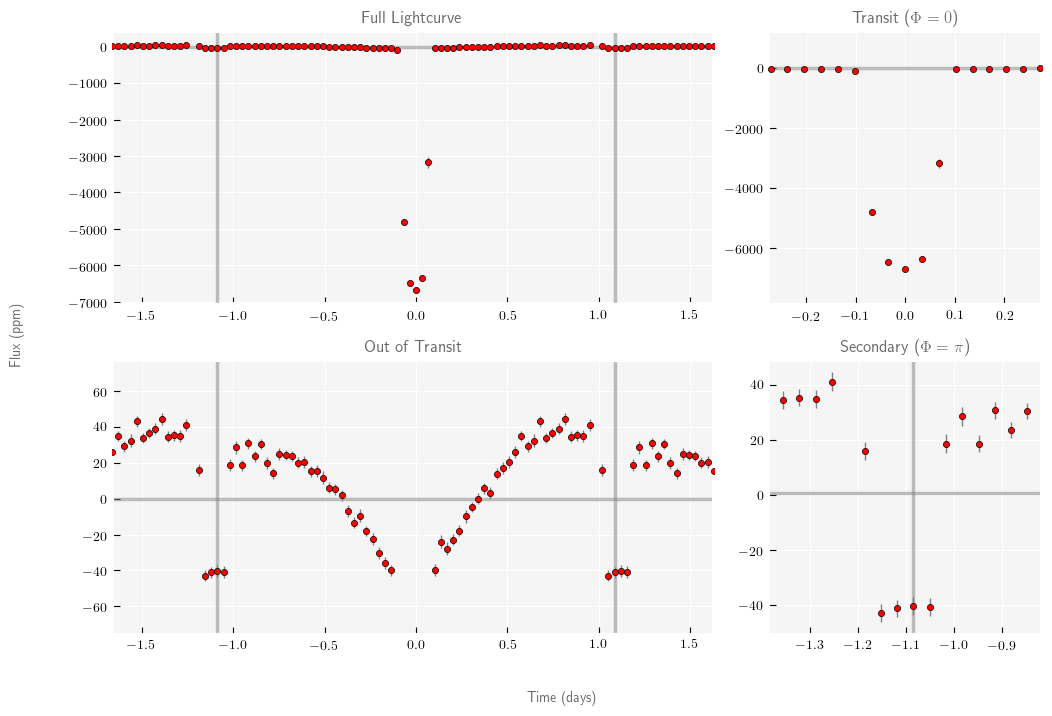

In [24]:
#kep = pylanet.data.getData(11017901,"./downloadedData/",cadence="both")
kep = pylanet.data.getData(2.01,"./downloadedData/",cadence="long")

rawTs=kep.times
rawFs=kep.sap_fluxs
rawEs=kep.sap_flux_errs

ts,fs,es=pylanet.data.cleanData(rawTs,rawFs,rawEs,kep.period,detrendMethod='box',nMin=1500)
print(ts.size,' data points')

sTs,sFs,sEs=pylanet.data.stackData(ts,fs,es,kep.period,nTs=64)

#sTs2,sFs2,sEs2=pylanet.data.stackData(ts,fs,es,kep.period,nTs=64)

thisFig,thisGrid=pylanet.plot.makeFig()
pylanet.plot.plotData(thisGrid,sTs,sFs,sEs,period=kep.period,c='r')
#pylanet.plot.plotData(thisGrid,sTs2,sFs2,sEs2,period=kep.period)
plt.show()

In [25]:
# params in order
"""
self.M=1 #stellar masses
self.R=1 #stellar radii
self.beta=1 #from equipotential theory

self.Mp=0.001
self.Rp=0.1

self.Ag=0.1

self.a=10
self.e=0.5
self.vTheta=np.pi/2
self.vPhi=0
self.tp=0 #time of periapse (if using real data with arbitrary t=0)
"""

'\nself.M=1 #stellar masses\nself.R=1 #stellar radii\nself.beta=1 #from equipotential theory\n\nself.Mp=0.001\nself.Rp=0.1\n\nself.Ag=0.1\n\nself.a=10\nself.e=0.5\nself.vTheta=np.pi/2\nself.vPhi=0\nself.tp=0 #time of periapse (if using real data with arbitrary t=0)\n'

In [26]:
def logprior(params,reportedP):
    if params[0] < 0.05 or params[0] > 5.:    #stellar mass
        return -np.inf
    if params[1] < 0.05 or params[1] > 5.:    #stellar radius
        return -np.inf
    
    if params[2] <= 0. or params[2] > 2.5:    #beta
        return -np.inf
    
    if params[3] < 1.e-7 or params[3] > 1.:   #planet mass
        return -np.inf
    if params[4] < 1.e-4 or params[4] > 1.:   #planet radius
        return -np.inf
    
    if params[5] < 0. or params[5] > 1.:      #geometric albedo
        return -np.inf
    
    #params[6] = a [Rsun]
    #params[7] = e
    #params[8] = vTheta = inc [rad]
    #params[9] = vPhi = pi/2 - omega  [rad]
    #params[10] = t0 (periapse time)
    
    aR = params[6]/params[1]
    
    if aR < 1.:
        return -np.inf
    
    ecc = params[7]
    inc = params[8]
    omega = (np.pi/2.) - params[9]
    
    b = aR * np.cos(inc) * ((1.-ecc**2)/(1.+ecc*np.sin(omega)))
    
    ror = params[4]/params[1]
    
    if b < 0. or b > (1. + ror):
        return -np.inf
    
    if b > params[6]:
        return -np.inf
    
    if params[10] < -0.5*reportedP or params[10] > 0.5*reportedP: #periapse time [days]
        return -np.inf
    
    return 0.0

In [27]:
def modelFlux(params,ts):
    #compare model LC to data
    
    #deltaLs, secondary eclipse from oot
    pl = oot.planet()
    pl.M, pl.R, pl.beta, pl.Mp, pl.Rp, pl.Ag, pl.a, pl.e, pl.vTheta, pl.vPhi, pl.tp = params
    
    delta = oot.deltaSum(ts,pl)
    
    #BATMAN transit
    bat = batman.TransitParams()
    
    bat.t0,bat.per,bat.rp,bat.a,bat.inc,bat.ecc,bat.w = oot.batman(pl)
    bat.limb_dark = "linear"
    bat.u = [0.6]
    
    batmodel = batman.TransitModel(bat,ts,supersample_factor = 30, exp_time = 0.020434, fac=0.005)
    batflux = batmodel.light_curve(bat)
    
    modelflux = batflux*(1.+delta)
    
    return modelflux

In [28]:
def loglike(params,ts,fs,es):
    modelflux = modelFlux(params,ts)
    
    residuals = np.empty_like(fs)
    residuals = fs - modelflux
    inverse_fluxerrsq = es**(-2)
    
    chisq = np.sum((residuals**2)*(inverse_fluxerrsq))
    
    logL = -0.5*np.sum(np.log(2.*np.pi*es**2)) - 0.5*chisq
    
    return logL

In [29]:
def logpost(params,ts,fs,es,reportedP):
    pl = oot.planet()
    pl.M, pl.R, pl.beta, pl.Mp, pl.Rp, pl.Ag, pl.a, pl.e, pl.vTheta, pl.vPhi, pl.tp = params
    
    if oot.checkTransit(pl) == -1:
        return -np.inf
    
    lp = logprior(params,reportedP)
    ll = loglike(params,ts,fs,es)

    if np.isfinite(lp)==False:
        return -np.inf
    
    if np.isfinite(ll)==False:
        return -np.inf
    
    return lp + ll

In [32]:
nwalkers=22
ndim=11
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=[ts, fs, es, kep.period])

pos = np.array((1.56,2.,1.,0.002,0.155,0.2,8.,0.006,(83.*np.pi/180.),0.5*np.pi,0.25))

pos = [pos + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [33]:
sampler.run_mcmc(pos, 50)

emcee: Exception while calling your likelihood function:
  params: [1.56112530e+00 2.00015691e+00 9.99659618e-01 2.58463459e-03
 1.55116406e-01 2.00267742e-01 7.99973491e+00 5.45948502e-03
 1.44923496e+00 1.57066587e+00 2.49535959e-01]
  args: [array([ 132.59507301,  132.61550744,  132.63594177, ..., 1556.83531618,
       1556.85575026, 1556.87618433]), array([-4.19616699e-05, -2.67028809e-05, -6.25848770e-05, ...,
       -2.96831131e-05, -3.57031822e-05, -5.40614128e-05]), array([2.55378618e-05, 2.55375580e-05, 2.55370742e-05, ...,
       2.55510822e-05, 2.55510731e-05, 2.55509149e-05]), 2.204735417]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/Emily/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-29-f49da99c5d12>", line 9, in logpost
    ll = loglike(params,ts,fs,es)
  File "<ipython-input-28-730e602914b2>", line 2, in loglike
    modelflux = modelFlux(params,ts)
  File "<ipython-input-27-bdd945acc55e>", line 17, in modelFlux
    batmodel = batman.TransitModel(bat,ts,supersample_factor = 30, exp_time = 0.020434, fac=0.005)
  File "/Users/Emily/anaconda2/lib/python2.7/site-packages/batman/transitmodel.py", line 106, in __init__
    for i in range(len(self.t)): ts.append(np.linspace(self.t[i] - self.exp_time/2., self.t[i] + self.exp_time/2., self.supersample_factor))
  File "/Users/Emily/anaconda2/lib/python2.7/site-packages/numpy/core/function_base.py", line 108, in linspace
    start = asanyarray(start) * 1.0
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
lastStep = sampler.chain[:,-1,:]

labels=['M','R','beta','Mp','Rp','Ag','a','e','vTheta','vPhi','tp']

for i in range(0,len(sampler.chain[0,0,:])):
    fig = plt.figure(figsize=(8,2))
    for j in range(0,len(sampler.chain[:,0,0])):
        plt.plot(sampler.chain[j,:,i])
    plt.ylabel(labels[i])
    plt.show()

In [ ]:
print(np.shape(sampler.flatchain))

In [ ]:
modelTs = np.linspace(-kep.period/2.,kep.period/2.,100)
modelFs = modelFlux(sampler.flatchain[-1],modelTs) - 1.

thisFig,thisGrid=pylanet.plot.makeFig()
pylanet.plot.plotData(thisGrid,sTs,sFs,sEs,period=kep.period)
pylanet.plot.plotModel(thisGrid,modelTs,modelFs,period=kep.period)
plt.show()